In [1]:
# Importing the libraries
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch

In [2]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder('/kaggle/input/animal-resnet/mammals', transform=transform)
print(len(full_dataset))

4500


In [3]:
test_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - test_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [4]:
resnet = models.resnet18(pretrained=False)

num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 30)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [22]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [23]:
epochs = 10

for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

    # Test loop
    resnet.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Loss: {test_loss/len(test_loader)}, Accuracy: {100 * correct / total}%')

Epoch 1/10, Loss: 0.005869653008968891
Test Loss: 2.2440873590008965, Accuracy: 46.77777777777778%
Epoch 2/10, Loss: 0.006838238294302296
Test Loss: 2.243983811345594, Accuracy: 46.111111111111114%
Epoch 3/10, Loss: 0.005917029318284342
Test Loss: 2.244329933462472, Accuracy: 45.888888888888886%
Epoch 4/10, Loss: 0.0058366932248927455
Test Loss: 2.2294144835965386, Accuracy: 46.22222222222222%
Epoch 5/10, Loss: 0.006040492895537312
Test Loss: 2.2448662190601745, Accuracy: 46.666666666666664%
Epoch 6/10, Loss: 0.004845574449756042
Test Loss: 2.2536411079867134, Accuracy: 45.22222222222222%
Epoch 7/10, Loss: 0.005382740500267694
Test Loss: 2.2380191005509475, Accuracy: 45.0%
Epoch 8/10, Loss: 0.005793495234555309
Test Loss: 2.240461300159323, Accuracy: 47.55555555555556%
Epoch 9/10, Loss: 0.0047668799205757345
Test Loss: 2.2475857405826964, Accuracy: 46.888888888888886%
Epoch 10/10, Loss: 0.004852262726342058
Test Loss: 2.2644098668262878, Accuracy: 45.0%


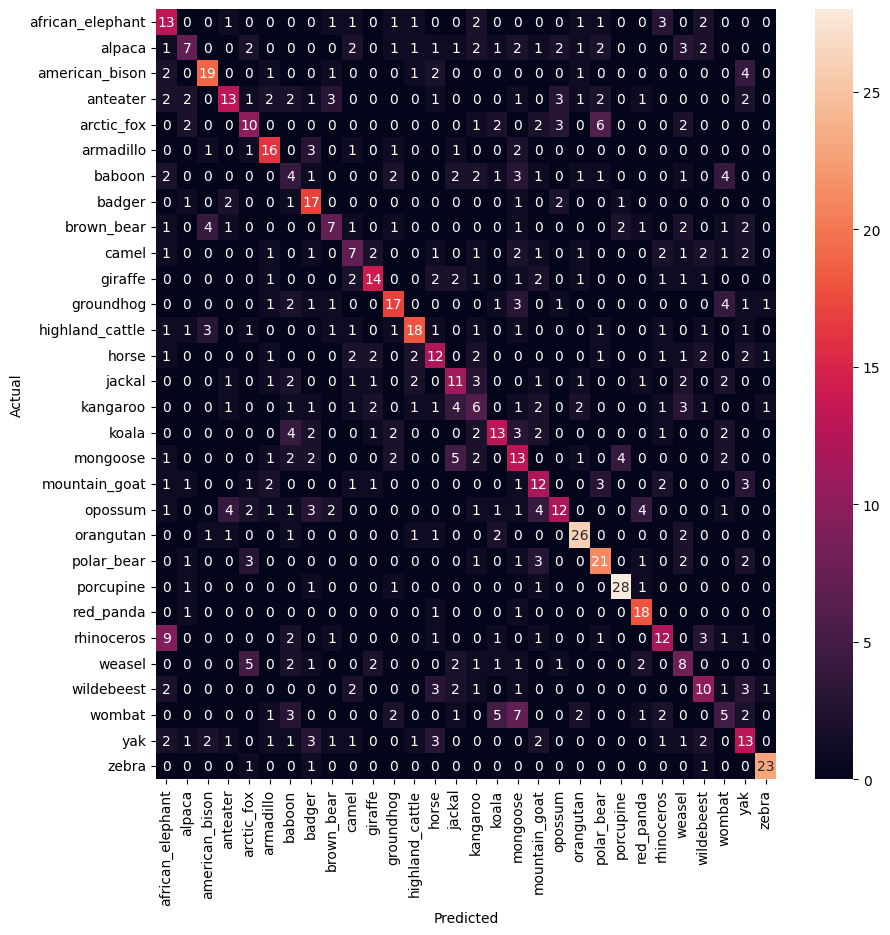

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predlist = torch.zeros(0, dtype=torch.long, device='cpu')
lbllist = torch.zeros(0, dtype=torch.long, device='cpu')

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)  # Changed to resnet
        _, preds = torch.max(outputs, 1)
        predlist = torch.cat([predlist, preds.view(-1).cpu()])
        lbllist = torch.cat([lbllist, labels.view(-1).cpu()])

conf_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=test_dataset.dataset.classes,
            yticklabels=test_dataset.dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [25]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

resnet.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)  # Changed to resnet
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

class_report = classification_report(all_labels, all_preds, target_names=full_dataset.classes)

print(class_report)
     

                  precision    recall  f1-score   support

african_elephant       0.33      0.48      0.39        27
          alpaca       0.39      0.22      0.28        32
  american_bison       0.63      0.61      0.62        31
        anteater       0.52      0.35      0.42        37
      arctic_fox       0.37      0.36      0.36        28
       armadillo       0.53      0.62      0.57        26
          baboon       0.14      0.16      0.15        25
          badger       0.45      0.68      0.54        25
      brown_bear       0.39      0.29      0.33        24
           camel       0.30      0.27      0.29        26
         giraffe       0.56      0.48      0.52        29
       groundhog       0.55      0.52      0.53        33
 highland_cattle       0.64      0.53      0.58        34
           horse       0.40      0.40      0.40        30
          jackal       0.35      0.38      0.37        29
        kangaroo       0.21      0.21      0.21        29
           ko